Epoch [1/100], Loss: 38.6192
Epoch [2/100], Loss: 29.2286
Epoch [3/100], Loss: 27.6268
Epoch [4/100], Loss: 27.4035
Epoch [5/100], Loss: 27.2970
Epoch [6/100], Loss: 27.2441
Epoch [7/100], Loss: 27.1997
Epoch [8/100], Loss: 27.1962
Epoch [9/100], Loss: 27.1751
Epoch [10/100], Loss: 27.1107
Epoch [11/100], Loss: 26.8828
Epoch [12/100], Loss: 26.5750
Epoch [13/100], Loss: 26.3838
Epoch [14/100], Loss: 26.1320
Epoch [15/100], Loss: 25.9493
Epoch [16/100], Loss: 25.8511
Epoch [17/100], Loss: 25.8371
Epoch [18/100], Loss: 25.7515
Epoch [19/100], Loss: 25.6164
Epoch [20/100], Loss: 25.5301
Epoch [21/100], Loss: 25.4166
Epoch [22/100], Loss: 25.3458
Epoch [23/100], Loss: 25.2687
Epoch [24/100], Loss: 25.2167
Epoch [25/100], Loss: 25.2669
Epoch [26/100], Loss: 25.1804
Epoch [27/100], Loss: 25.1845
Epoch [28/100], Loss: 25.1064
Epoch [29/100], Loss: 25.0455
Epoch [30/100], Loss: 25.1024
Epoch [31/100], Loss: 25.0049
Epoch [32/100], Loss: 25.0853
Epoch [33/100], Loss: 25.0516
Epoch [34/100], Los

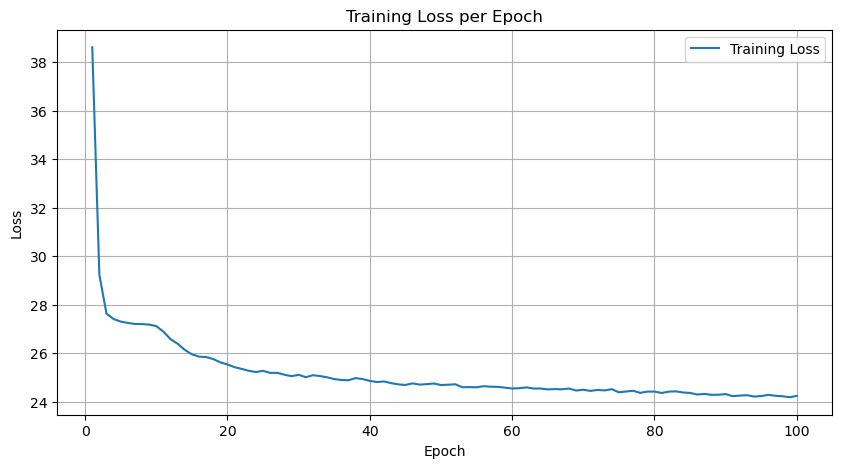

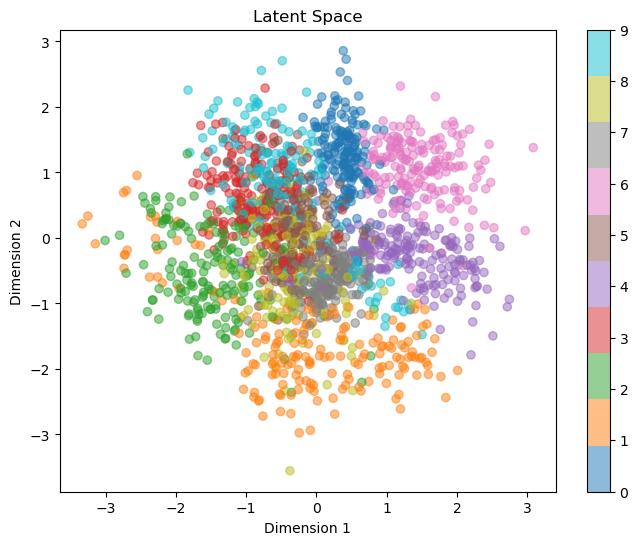

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# データをロードします
digits = load_digits()
data = digits.data
targets = digits.target

# データを正規化します
data = data / 16.0  # 0-16までの整数値なので16で割って正規化

# NumPy配列をPyTorchのテンソルに変換します
data = torch.tensor(data, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.int64)

# TensorDatasetとDataLoaderを構築
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        # エンコーダー: 入力層 -> 隠れ層1 -> 隠れ層2 -> 平均と標準偏差の線形層
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        
        # デコーダー: 潜在空間 -> 隠れ層1 -> 隠れ層2 -> 出力層
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    # バイナリ クロスエントロピ 損失と KL ダイバージェンス
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
    
# モデルの設定
input_dim = data.shape[1]  # 64 (8x8画像)
hidden_dim1 = 128
hidden_dim2 = 64
latent_dim = 2

# モデル、損失関数、最適化手法の設定
model = VAE(input_dim, hidden_dim1, hidden_dim2, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習を行います
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_data, _ in dataloader:
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(batch_data)
        loss = loss_function(reconstructed, batch_data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(dataloader.dataset)
    
    losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# 損失のプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 全データを用いて潜在変数を取得してプロット
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(data)
    latent_space = model.reparameterize(mu, logvar).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], alpha=0.5, c=targets, cmap='tab10')
plt.colorbar()
plt.title('Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [2]:
# モデルを評価モードに変更
model.eval()
with torch.no_grad():
    # 先頭10件の訓練データを選択（X_trainはすでにTensorとして定義済み）
    sample_data = data[:10]
    # エンコーダを通して mu と logvar を取得
    mu, logvar = model.encode(sample_data)
    # sigma^2 を計算（σ^2 = exp(log σ^2)）
    sigma_squared = torch.exp(logvar)
    
    print("Selected training samples sigma^2:")
    print(sigma_squared)


Selected training samples sigma^2:
tensor([[0.0345, 0.1340],
        [0.1302, 0.1818],
        [0.1138, 0.1639],
        [0.1356, 0.1719],
        [0.1339, 0.0675],
        [0.1159, 0.1789],
        [0.1498, 0.1011],
        [0.0337, 0.0349],
        [0.1425, 0.1887],
        [0.0817, 0.1548]])


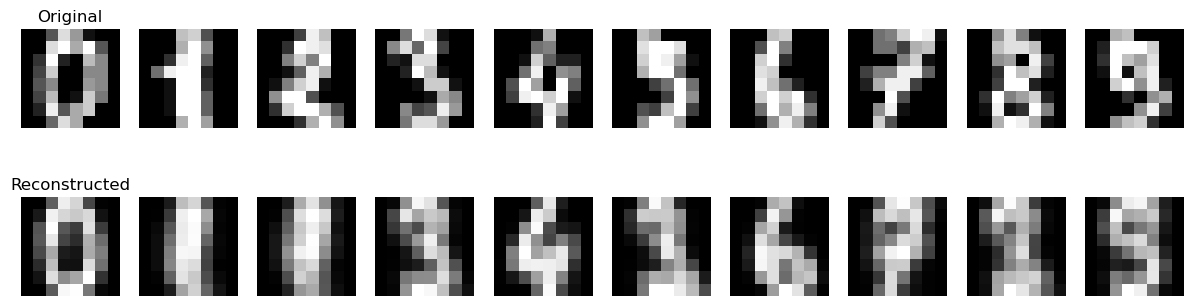

In [3]:
import matplotlib.pyplot as plt

# 訓練済みモデルを評価モードに切り替え
model.eval()

# 入力データをモデルに通して再構成を取得
with torch.no_grad():
    reconstructed_data, _ , _ = model(data)

# Tensor を numpy array に変換
input_data_np = data.numpy()
reconstructed_data_np = reconstructed_data.numpy()

# 比較するための画像数を設定
num_images_to_show = 10  # 例えば最初の10個を表示

# 図示
fig, axes = plt.subplots(nrows=2, ncols=num_images_to_show, figsize=(15, 4))
for i in range(num_images_to_show):
    # 入力画像
    axes[0, i].imshow(input_data_np[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    
    # 再構成画像
    axes[1, i].imshow(reconstructed_data_np[i].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original", fontsize=12)
axes[1, 0].set_title("Reconstructed", fontsize=12)

plt.show()

In [4]:
# ユーザー追加

factor = 0.5
(x1, y1), (x2, y2) = (latent_space.min(axis=0) - latent_space.ptp(axis=0)*factor,
                      latent_space.max(axis=0) + latent_space.ptp(axis=0)*factor)

print("xrange", x1,x2)
print("yrange", y1,y2)

xrange -6.535774 6.288335
yrange -6.7602205 6.0651464


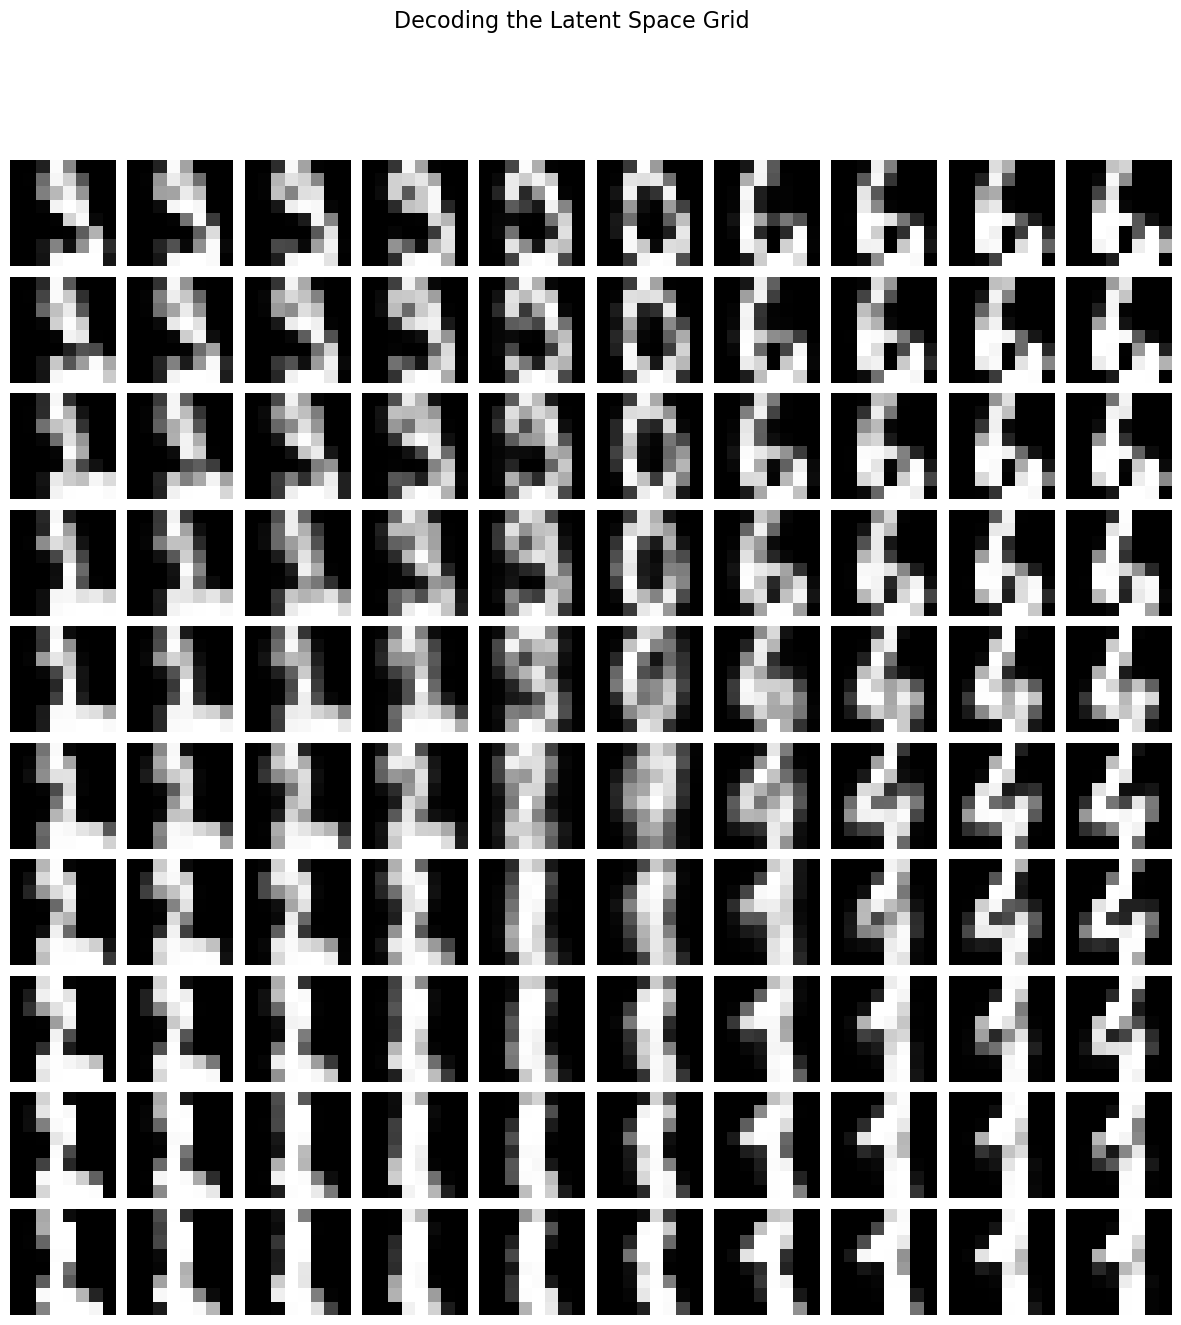

In [5]:
import numpy as np

# 潜在空間を10x10のグリッドに分割
x_range = (x1, x2)
y_range = (y2, y1)

# 分割数
n_bins = 10

# 潜在空間を10x10のグリッドに分割
fig, axarr = plt.subplots(n_bins, n_bins, figsize=(15, 15))

x_bins = np.linspace(x_range[0], x_range[1], n_bins)
y_bins = np.linspace(y_range[0], y_range[1], n_bins)

# 各グリッドに対応する潜在コードからデコードされた各画像を表示
for i, x_val in enumerate(x_bins):
    for j, y_val in enumerate(y_bins):
        # 選ばれた潜在変数のグリッドでの座標
        z = torch.tensor([[x_val, y_val]], dtype=torch.float32)

        # デコードして画像を生成
        with torch.no_grad():
            generated = model.decoder(z).numpy().reshape(8, 8)

        # 画像をプロット
        axarr[j, i].imshow(generated, cmap='gray')
        axarr[j, i].axis('off')

plt.suptitle('Decoding the Latent Space Grid', fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()